# Plotting LWP PDFs

Here, we analyse liquid water path (LWP) PDFs

Some Ideas:
* LWP should be binned in log intervals
* We could look at PDF or fraction or mass contributions

Some maths:

If $P$ is the probability to find LWP (here symbol $Q_c$ is used) in a certain interval $\ln Q_c$, than the probability density function can be written as
$$
p = \frac{dP}{d\ln Q_c}
$$

The total domain area is defined as
$$
A_\mathrm{tot} = \int_0^\infty d\ln Q_c' \; a(\ln Q_c') 
\approx \overline{\Delta a} \int_0^\infty d\ln Q_c' \;p
$$
where $ a(\ln Q_c') $ is the area covered in a certain $\ln Q_c$ interval and $\overline{\Delta a}$ is the average grid box area.

The total liquid mass is defined as
$$
M_{c,\mathrm{tot}} = \int_0^\infty d\ln Q_c' \; a(\ln Q_c') \,Q_c'
\approx \overline{\Delta a} \int_0^\infty d\ln Q_c' \;p\, Q_c
$$


## Import Libraries

In [2]:
%matplotlib inline

import sys, os
import datetime
import numpy as np
import xarray as xr
import importlib
import scipy.ndimage

import pylab as plt
plt.rcParams['figure.figsize'] = (12,8)
import seaborn as sns
sns.set_context( 'talk' )

from cycler import cycler


# import nawdex_analysis.io.tools

/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
tools_dir = '%s/proj/2017-11_icon-de-lem-analysis/tools' % os.environ['HOME']

import sys
sys.path.append(tools_dir)

In [4]:
import input_regrid5km
importlib.reload( input_regrid5km )

<module 'input_regrid5km' from '/pf/b/b380352/proj/2017-11_icon-de-lem-analysis/tools/input_regrid5km.py'>

## Open LWP Data 

The data have been combined with the script:
    
```
/mnt/lustre01/pf/b/b380352/proj/2017-11_icon-de-lem-analysis/inout/combine_lwp_field.py
```

In [5]:
lwp = xr.open_dataset( '%s/icon-lem/aggregates/lwp_combined.nc' % os.environ['LOCAL_DATA_PATH'] )

In [6]:
lwp.load()

lwp = lwp * 1e3
lwp['clwvi'].attrs['units'] = 'g m-3'
lwp['clwvi'].attrs['long_name'] = 'liquid-water path'
lwp['clwvi'].attrs['standard_name'] = '$Q_c$'

lwp['clwvi'].attrs

{'units': 'g m-3', 'long_name': 'liquid-water path', 'standard_name': '$Q_c$'}

## Plot Average LWP Time Series

In [7]:
lwp_mean = lwp.mean(['lon', 'lat']).compute()

/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [8]:
lwp_mean.time

<xarray.DataArray 'time' (time: 19)>
array(['2013-05-02T06:00:00.000000000', '2013-05-02T07:00:00.000000000',
       '2013-05-02T08:00:00.000000000', '2013-05-02T09:00:00.000000000',
       '2013-05-02T10:00:00.000000000', '2013-05-02T11:00:00.000000000',
       '2013-05-02T12:00:00.000000000', '2013-05-02T13:00:00.000000000',
       '2013-05-02T14:00:00.000000000', '2013-05-02T15:00:00.000000000',
       '2013-05-02T16:00:00.000000000', '2013-05-02T17:00:00.000000000',
       '2013-05-02T18:00:00.000000000', '2013-05-02T19:00:00.000000000',
       '2013-05-02T20:00:00.000000000', '2013-05-02T21:00:00.000000000',
       '2013-05-02T22:00:00.000000000', '2013-05-02T23:00:00.000000000',
       '2013-05-03T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2013-05-02T06:00:00 ... 2013-05-03

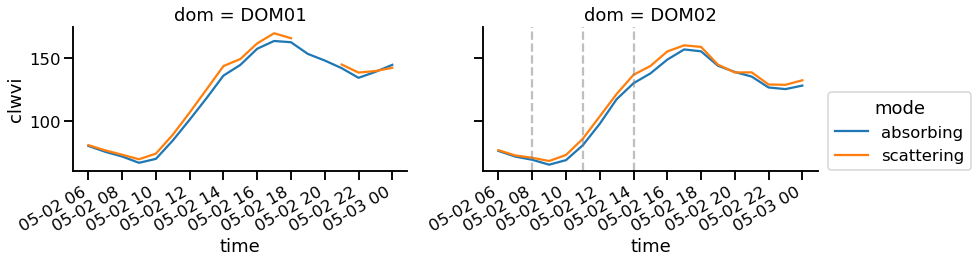

In [9]:
lwp_mean['clwvi'].plot(col = 'dom', hue = 'mode', x = 'time', figsize = (12,4))
for h in [8,11, 14]:
    plt.axvline(lwp.time.sel(time = '2013-05-02T%s' % str(h).zfill(2)).data, c = 'gray', alpha = 0.5, ls = '--')
sns.despine()

## Calculate PDFs

### Select Time Range

In [10]:
t_start = '2013-05-02T08'
t_end = '2013-05-02T14'


In [11]:
Q_c = lwp['clwvi'].sel(time = slice(t_start, t_end))

### Histogram Binning

In [12]:
Qbins = 10**np.linspace(-3, 4, 60)

In [13]:
def calc_hist(f, bins = Qbins, log_binning = True, sigma = 0.,
                moment = 0,
                density = True):

    total_size = 1. * np.size( f )
    
    quantity = f**moment
    
    
    Nbins = len(bins)
    h = []
    for n in range(Nbins - 1):
        b1 = bins[n]
        b2 = bins[n+1]

        # including the right-most edge (like numpy)
        m = (f > b1) & (f <= b2)

        h += [quantity[m].sum(), ]

    h = np.array( h )
    
    if sigma > 0:
        h = scipy.ndimage.gaussian_filter1d( h, sigma )
        
    if density:
        if log_binning:
            dbin = np.diff( np.log(bins) )
        else:
            dbin = np.diff( bins )

        return h / total_size / dbin
    else:
        return h


In [14]:
d = xr.Dataset()
d['PDF'] = xr.apply_ufunc(calc_hist, Q_c, 
                             input_core_dims=[['lon', 'lat'], ],
                             output_core_dims=[['bins']],
                             vectorize=True, kwargs = dict(bins = Qbins, moment = 0, sigma = 3))

Qbins_c = 0.5*(Qbins[1:] + Qbins[:-1])
d['bins'] = xr.DataArray(data = Qbins_c, dims = 'bins')

In [15]:
d['contrib'] = xr.apply_ufunc(calc_hist, Q_c, 
                             input_core_dims=[['lon', 'lat'], ],
                             output_core_dims=[['bins']],
                             vectorize=True, kwargs = dict(moment = 1, sigma = 3))

Qbins_c = 0.5*(Qbins[1:] + Qbins[:-1])
d['bins'] = xr.DataArray(data = Qbins_c, dims = 'bins')

In [16]:
d = input_regrid5km.get_difference( d )

In [17]:
ddiff = d.sel(mode = 'difference')

## PDFs for different time ranges

In [18]:
range1 = slice('2013-05-02T08', '2013-05-02T11')
range2 = slice('2013-05-02T11', '2013-05-02T14')


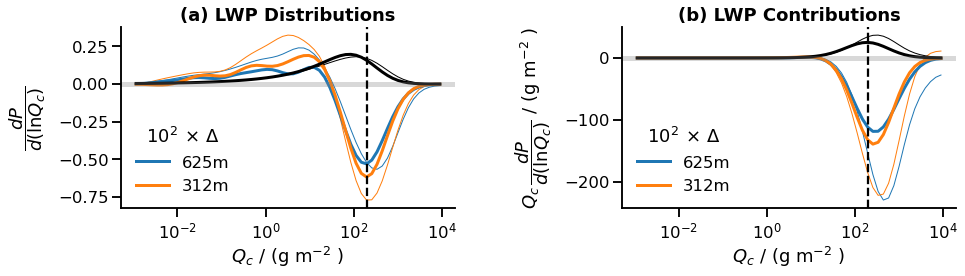

In [23]:
figs, ax = plt.subplots( ncols = 2, figsize = (16, 4))
plt.subplots_adjust( wspace = 0.5, bottom = 0.25, right = 0.85)


## plot PDF
# =========
plt.sca( ax[0])

scale = 1e2
vname = 'PDF'

# range2
dsel = ddiff.sel( time = range2 )
dm = d.sel( time = range2, mode = ['scattering','absorbing'] ).mean(['time', 'dom', 'mode'])

dsel['dom'] = ['625m', '312m']
(scale * dsel[vname]).mean('time').plot(hue = 'dom', lw = 1,)
(dm[vname]).plot( c = 'k', lw = 1)

# range1
dsel = ddiff.sel( time = range1 )
dm = d.sel( time = range1, mode = ['scattering','absorbing'] ).mean(['time', 'dom', 'mode'])


ax[0].set_prop_cycle(None)
dsel['dom'] = ['625m', '312m']
( scale * dsel[vname]).mean('time').plot(hue = 'dom', lw = 3)
(dm[vname]).plot( c = 'k', lw = 3)





plt.xscale('log')
plt.ylabel('$\dfrac{dP}{d(\ln Q_c)}$', labelpad = 10)
plt.xlabel(r'$Q_c$ / (g m${}^{-2}$ )')
plt.title('(a) LWP Distributions', fontweight = 'bold')

plt.axhline(0, color = 'gray', alpha = 0.3, lw = 5)
plt.axvline(200., color = 'k', ls = '--')

sns.despine()

legend = plt.gca().get_legend()
legend.set_frame_on( False )
legend.set_title(r'$10^2\,\times\,\Delta$')

## plot contribution
# ==================
plt.sca( ax[1])

scale = 1e2
vname = 'contrib'

# range2
dsel = ddiff.sel( time = range2 )
dm = d.sel( time = range2, mode = ['scattering','absorbing'] ).mean(['time', 'dom', 'mode'])

(scale * dsel[vname]).mean('time').plot(hue = 'dom', lw = 1,)
(dm[vname]).plot( c = 'k', lw = 1)

# range1
dsel = ddiff.sel( time = range1 )
dsel['dom'] = ['625m', '312m']

dm = d.sel( time = range1, mode = ['scattering','absorbing'] ).mean(['time', 'dom', 'mode'])


ax[1].set_prop_cycle(None)
( scale * dsel[vname]).mean('time').plot(hue = 'dom', lw = 3)
(dm[vname]).plot( c = 'k', lw = 3)



plt.xscale('log')
plt.xlabel(r'$Q_c$ / (g m${}^{-2}$ )')
plt.ylabel(r'$Q_c \, \dfrac{dP}{d(\ln Q_c)}$ / (g m${}^{-2}$ )', labelpad = 10)
plt.title('(b) LWP Contributions', fontweight = 'bold')

plt.axhline(0, color = 'gray', alpha = 0.3, lw = 5)
plt.axvline(200., color = 'k', ls = '--')
sns.despine()


legend = plt.gca().get_legend()
legend.set_frame_on( False )
legend.set_title(r'$10^2\,\times\,\Delta$')

plt.savefig('../pics/lwp-changes.png', dpi = 300.)
